# Implementation Exercise:
### _Return Predictability and Dynamic Asset Allocation: How Often Should Investors Rebalance?_
by _Himanshu Almadi, David E. Rapach, and Anil Suri_

### Results Overview

1. The optimal portfolio wegiths for both original optimization problem and simple robust allocation problem reduced the proportion of investment in stock during recession and market crashes

![image1](./image/recession_plot.png)

2. Based on various performance measures, the Robust Allocation was the most optimal strategy and the original formulation was more optimal than the benchmark scenario; that is, to invest 65% in stock, 30% in bond, and 5% in bill. 

![image](./image/table.png)

`Robust vs Original` values are obtained by treating `original formulation` as the benchmark portfolio

3. The robust allocation was not sensitive to small perturbations to $\Sigma_{BL}$.

The distriution of perturbed performance measures from `N=100` simulation was as following:

![image](./image/perturb.png)

## 1. Processing data from Bloomberg Terminal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from gurobipy import *

In [27]:
def process_xlsx(filename,filetype = 'Bloomberg'):
    """
    process .xlsx files downloaded from Bloomberg and Factset
    """
    file = './data/' + filename
    if filetype == 'Bloomberg':
        df = pd.read_excel(file,header=5)
        df.rename(columns = {'Unnamed: 0':'dates'},inplace=True)
        df.loc[:,'Dates']=pd.to_datetime(df['Dates'])
    if filetype == 'Bonds':
        df = pd.read_excel(file,header=3,parser='Date')
    if filetype == 'Bills':
        df = pd.read_excel(file,header=20,parser='Date')
    return df.reset_index(drop=True)

In [28]:
other_df = process_xlsx('others.xlsx')
other_df.tail()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
350,2019-03-29,2834.40,1.43,254.148,NaN,NaN,4.84,3.77,109.6691
351,2019-04-30,2945.83,4.71,254.958,NaN,NaN,4.70,3.69,108.9651
352,2019-05-31,2752.06,11.51,255.155,NaN,2.2875,4.63,3.67,109.2243
353,2019-06-28,2941.76,0.58,255.305,NaN,2.0388,4.46,3.42,109.4144
354,2019-07-31,2980.38,4.25,256.161,NaN,2.0113,4.28,3.29,109.1756


In [29]:
df_bonds = process_xlsx('./facset/US10YY-TU1.xlsx','Bonds')
df_bonds.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,8.43,NaN,NaN,NaN,8.43,0.000000,NaN,NaN,NaN
1,1990-02-28,8.51,NaN,0.080000,0.948991,8.51,0.948992,NaN,NaN,NaN
2,1990-03-30,8.65,NaN,0.139999,1.645116,8.65,2.609727,NaN,NaN,NaN
3,1990-04-30,9.04,NaN,0.390000,4.508675,9.04,7.236062,NaN,NaN,NaN
4,1990-05-31,8.60,NaN,-0.440000,-4.867252,8.60,2.016607,NaN,NaN,NaN


In [30]:
df_bill = process_xlsx('./facset/TRYUS3M-FDS.xlsx','Bills')
df_bill.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,7.74,NaN,NaN,NaN,7.74,0.000000,NaN,NaN,NaN
1,1990-02-28,7.77,NaN,0.03,0.387600,7.77,0.387597,NaN,NaN,NaN
2,1990-03-30,7.80,NaN,0.03,0.386103,7.80,0.775194,NaN,NaN,NaN
3,1990-04-30,7.79,NaN,-0.01,-0.128208,7.79,0.645995,NaN,NaN,NaN
4,1990-05-31,7.75,NaN,-0.04,-0.513478,7.75,0.129199,NaN,NaN,NaN


## 2. Processing Explanatory Variables

### 2.1 log(D/P)

More specifically, I am computing the following:
$$ log(\sum_{s=1}^{12} D_{t-(s-1)}) - log(P_{t}) $$
where `D` stands for dividens paid by `SP500` constituents at time t. 
And `P` stands for `SP500` at time t.


As a sanity check, I wanted to check there are only two `NaN` values for `SPXDIV Index`

In [31]:
other_df['SPXDIV Index'].isna().sum()

2

In [32]:
other_df.head()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
0,NaT,329.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,331.89,NaN,128.0,NaN,NaN,10.14,9.22,64.0446
2,1990-03-30,339.94,0.31,128.6,NaN,NaN,10.21,9.37,64.3580
3,1990-04-30,330.80,0.98,128.9,NaN,NaN,10.30,9.46,64.2602
4,1990-05-31,361.23,2.74,129.1,NaN,NaN,10.41,9.47,64.3973


In [8]:
df = pd.DataFrame([])
df['Dates'] = other_df['Dates']
df['log_DP'] = (other_df['SPXDIV Index'].rolling(12).sum().apply('log').shift()
                - other_df['SPX Index'].apply('log'))

In [9]:
df[['Dates','log_DP']][13:].head()

,Dates,log_DP
13,1991-02-28,NaN
14,1991-03-29,-3.184739
15,1991-04-30,-3.187664
16,1991-05-31,-3.221650
17,1991-06-28,-3.175793


Compare 14th row with following for sanity check:

In [10]:
np.log(sum(other_df['SPXDIV Index'][2:14])) \
- np.log(other_df['SPX Index'][14])

-3.1847388834548687

### 2.2 Inflation

Inflation is calculated by CPI Index. The research paper writes following: 
<br>
_We account for the delay in the release of monthly CPI data when computing the forecast_
<br>
My susequent search suggested that  CPI Index is released with lag of 1 month.
<br>
Thus, I adjust for the issue by shifting CPI Index level by 1.
$$ inflation_{t} = \frac{CPI_{t}}{CPI_{t-1}}$$
However, at time t, the most recent available inflation rate is that of time t-1.


In [11]:
df['inflation'] = other_df['CPI INDX Index'].pct_change().shift()

In [12]:
df[['Dates','inflation']].head()

,Dates,inflation
0,NaT,NaN
1,1990-02-28,NaN
2,1990-03-30,NaN
3,1990-04-30,0.004687
4,1990-05-31,0.002333


Following is a sanity check. inflation rate for 2nd row is consistent with third row of inflation columns. The rationale for this is explained at the Markdown Cell above

In [13]:
(other_df['CPI INDX Index'][2]/other_df['CPI INDX Index'][1] -1)

0.004687499999999956

### 2.3 Term Spread

Term spread refers to the difference between 10-year Treasury bond yield and the three-month Treasury bill yield.


In [14]:
df['Term_Spread'] = df_bonds['Close'] - df_bill['Close']

In [15]:
df[['Dates','Term_Spread']].head()

,Dates,Term_Spread
0,NaT,0.690001
1,1990-02-28,0.740000
2,1990-03-30,0.849999
3,1990-04-30,1.250000
4,1990-05-31,0.850000


### 2.4 Default Spread

The difference between Moody's BAA and AAA rated corporate Bond yields

In [16]:
df['Default_Spread']=other_df['MOODCBAA Index'] \
                        - other_df['MOODCAAA Index']

In [17]:
df[['Dates','Default_Spread']].head()

,Dates,Default_Spread
0,NaT,NaN
1,1990-02-28,0.92
2,1990-03-30,0.84
3,1990-04-30,0.84
4,1990-05-31,0.94


As with `term spread`, a few observation would be sufficient for a sanity check as it only requires a subtraction

In [18]:
other_df[['Dates','MOODCBAA Index','MOODCAAA Index']].head()

,Dates,MOODCBAA Index,MOODCAAA Index
0,NaT,NaN,NaN
1,1990-02-28,10.14,9.22
2,1990-03-30,10.21,9.37
3,1990-04-30,10.30,9.46
4,1990-05-31,10.41,9.47


### 2.5  Moving Averages

Average of `SPX Index` for the past 12-months.
<br>
$$ MA_{t} = \frac{\sum_{i=0}^{11} SPX_{t-i}}{12}$$

In [19]:
Moving_Average_12 = other_df['SPX Index'].rolling(12).mean()

In [20]:
Moving_Average_12[10:].head()

10           NaN
11    332.680000
12    333.917500
13    336.849167
14    339.789167
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [21]:
np.mean(other_df['SPX Index'][:12])

332.68000000000006

In [22]:
Moving_Average_2 = other_df['SPX Index'].rolling(2).mean()

In [23]:
Moving_Average_2.head()

0        NaN
1    330.485
2    335.915
3    335.370
4    346.015
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [24]:
np.mean(other_df['SPX Index'][:2])

330.485

In [25]:
Bond_Moving_Average_12 = df_bonds['Close'].rolling(12).mean()

In [26]:
Bond_Moving_Average_12[10:].head()

10         NaN
11    8.557500
12    8.524167
13    8.483333
14    8.433333
Name: Close, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [27]:
df_bonds['Close'][:12].mean()

8.557499965031942

In [28]:
Bond_Moving_Average_6 = df_bonds['Close'].rolling(6).mean()

In [29]:
Bond_Moving_Average_6[5:].head()

5    8.610000
6    8.598333
7    8.656667
8    8.685000
9    8.620000
Name: Close, dtype: float64

In [30]:
np.mean(df_bonds['Close'][:6])

8.610000133514404

### 2.5.1 MA(1,12) 

It is a dummy variable based on `SPX Index` level and `Moving_Average_12`
<br>
If `SPX Index` value is greater than its 12 months moving average, then assign 1. Otherwise assign 0.

In [31]:
MA_nan = ((other_df['SPX Index']-Moving_Average_12)
          .apply(lambda x: np.nan if np.isnan(x) else 0))

In [32]:
df['MA_1_12']=((other_df['SPX Index']-Moving_Average_12)
               .apply(lambda x: 1 if x>0 else 0) + MA_nan)

In [33]:
df[['Dates','MA_1_12']][9:].head()

,Dates,MA_1_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


As a sanity check, since Moving_Average_12 is already checked, following shows that lambda function performs as expected.

In [34]:
(other_df['SPX Index']-Moving_Average_12)[9:].head()

9           NaN
10          NaN
11    -2.460000
12    10.012500
13    30.220833
Name: SPX Index, dtype: float64

### 2.5.2 MA(2,12) 

It is a dummy variable based on `Moving_Average_2`  and `Moving_Average_12`
<br>
If `Moving_Average_2` value is greater than `Moving_Average_12` value, then assign 1. Otherwise assign 0.

In [35]:
df['MA_2_12']=((Moving_Average_2-Moving_Average_12)
               .apply(lambda x: 1 if x>0 else 0) + MA_nan)

In [36]:
df[['Dates','MA_2_12']][9:].head()

,Dates,MA_2_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


### 2.5.3 MOMBY(6) 

It is a dummy variable based on `Bond_Moving_Average_6`  and the current bond yield.
<br>
If the bond yield is greater than `Bond_Moving_Average_6` by more than 5 basis points, assign -1. 
<br>
Else if the bond yield is less than `Bond_Moving_Average_6` by more than 5 basis points, assign 1.
<br>
Otherwie, assign 0.

In [37]:
MOMBY_6_nan = (df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [38]:
df['MOMBY_6']=((df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0)) 
               + MOMBY_6_nan)

In [39]:
df[['Dates','MOMBY_6']][5:].head()

,Dates,MOMBY_6
5,1990-06-29,1.0
6,1990-07-31,1.0
7,1990-08-31,-1.0
8,1990-09-28,-1.0
9,1990-10-31,1.0


### 2.5.3 MOMBY(12) 

In [40]:
MOMBY_12_nan = (df_bonds['Close']-Bond_Moving_Average_12
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [41]:
df['MOMBY_12']=((df_bonds['Close']-Bond_Moving_Average_12)
                .apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0))
                + MOMBY_12_nan)

In [42]:
df[['Dates','MOMBY_12']][11:].head()

,Dates,MOMBY_12
11,1990-12-31,1.0
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.6 MOM

It is a dummy variable that depends on `SPX Index` and its lagged values.

### 2.6.1 MOM(9)
If the difference between `SPX Index` and its 9 months lagged value is positive then assign 1. Otherwise assign 0.

In [43]:
MOM_9_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_9']=(other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_9_nan

In [44]:
df[['Dates','MOM_9']][8:].head()

,Dates,MOM_9
8,1990-09-28,NaN
9,1990-10-31,0.0
10,1990-11-30,0.0
11,1990-12-31,0.0
12,1991-01-31,1.0


Following checks the result

In [45]:
(other_df['SPX Index']-other_df['SPX Index'].shift(9))[8:].head()

8       NaN
9    -25.08
10    -9.67
11    -9.72
12    13.13
Name: SPX Index, dtype: float64

### 2.6.2 MOM(12)
If the difference between `SPX Index` and its 12 months lagged value is positive then assign 1. Otherwise assign 0.

In [46]:
MOM_12_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_12']=(other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_12_nan

In [47]:
df[['Dates','MOM_12']][11:].head()

,Dates,MOM_12
11,1990-12-31,NaN
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.7 Output Gap

The deviation of the log of industrial production from a quadratic trend.
<br>
I believe this data is available from Bloomberg Terminal. 
However, it is simple to compute. Therefore, I decided to simply compute it.
<br>
A quadratic trend is of the following form:
<br>
$$ y_{t} = \beta_{0} + \beta_{0}x_{t} + \beta_{0}x_{t}^2 +\epsilon_{t} $$
<br>
$\widehat{\beta}$ is estimated by $$\widehat{\beta} = (X^{T}X)^{-1}X^{T}y  $$

following provides an illustration of this estimation procedure.



In [48]:
def beta_est(obs):
    """
    estimates beta of ols to minimize l2 norm
    """
    y = np.log(other_df['IP Index'].dropna())[:obs]
    X = np.concatenate((np.ones(obs).reshape(-1,1),
                        np.arange(obs).reshape(-1,1)),
                       axis=1)
    X = np.concatenate((X,(np.arange(obs)**2)
                        .reshape(-1,1)),
                       axis=1)
    beta_hat = np.dot(
                  np.matmul(
                      np.linalg.inv(
                          1e-6 *np.eye(3) 
                          + np.matmul(X.transpose(),X)),
                            X.transpose()),
                  y.values.reshape(-1,1))
    return beta_hat

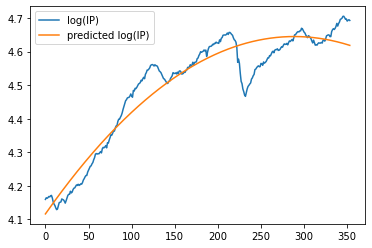

In [49]:
n = len(np.log(other_df['IP Index'].dropna()))
X = np.concatenate((np.ones(n).reshape(-1,1)
                    ,np.arange(n).reshape(-1,1)),
                   axis=1)
X = np.concatenate((X,(np.arange(n)**2)
                    .reshape(-1,1)),
                   axis=1)
beta_hat = beta_est(n)
y_pred = np.matmul(X,beta_hat)
y = np.log(other_df['IP Index'].dropna())
plot_df = np.concatenate((np.arange(n)
                          .reshape(-1,1),
                          y.values.reshape(-1,1),
                          y_pred),
                         axis=1)
plot_df = pd.DataFrame(plot_df)
plot_df.columns = ['obs','log(IP)','predicted log(IP)']
plt.plot('obs','log(IP)',data=plot_df)
plt.plot('obs','predicted log(IP)',data=plot_df)
plt.legend()

However, the research estimates $\widehat{\beta}$ from data available up to each point in time. Thus, I will repeat the calculation above to every time step.

In [50]:
def output_gap_computer(obs):
    """
    computes the deviation of the log of industrial 
    production from a quadratic trend.
    """
    return y[obs]-np.dot(X[:obs],beta_est(obs))[-1]

In [55]:
# Next Cell parallelize for loop. It is equivalent to

output_gap = []
for i in range(1,n+1):
    output_gap += [output_gap_computer(i)]

In [56]:
# pool = multiprocessing.Pool(4)
# output_gap =[*pool.map(output_gap_computer, range(1, n+1))]

In [57]:
df['output_gap']=np.concatenate(([np.nan],
                                 np.array(output_gap)
                                 .reshape(-1)))

In [58]:
df[['Dates','output_gap']].head()

,Dates,output_gap
0,NaT,NaN
1,1990-02-28,4.159576e-06
2,1990-03-30,2.422823e-09
3,1990-04-30,-5.646037e-09
4,1990-05-31,5.029228e-04


### 2.7 SPX Index return


In [59]:
df['r_SPX'] = other_df['SPX Index'].pct_change().shift(-1)
df[['Dates','r_SPX']].head()

,Dates,r_SPX
0,NaT,0.008539
1,1990-02-28,0.024255
2,1990-03-30,-0.026887
3,1990-04-30,0.091989
4,1990-05-31,-0.008886


### 2.8 Bond return and yield

In [60]:
def compound_return(cum_return):
    sol = (cum_return.values/100 + 1)
    for i in range(2,len(sol)):
       sol[i] = sol[i]/(cum_return.values/100 + 1)[i-1]
    return sol - 1


In [61]:
df['y_bond'] = df_bonds['Close']/100
df[['Dates','y_bond']].head()

,Dates,y_bond
0,NaT,0.0843
1,1990-02-28,0.0851
2,1990-03-30,0.0865
3,1990-04-30,0.0904
4,1990-05-31,0.0860


In [62]:
df['r_bond'] = (compound_return(
                    df_bonds['Cumulative Return %'].shift(-1)))
df[['Dates','r_bond']].head()

,Dates,r_bond
0,NaT,0.009490
1,1990-02-28,0.026097
2,1990-03-30,0.045087
3,1990-04-30,-0.048673
4,1990-05-31,-0.019767


To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bond` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1.026097) = (1.009490)(1 + r) \Rightarrow r = 0.016451$$
$$ (1.072361) = (1.009490)(1.016451)(1 + r) \Rightarrow r = 0.045087 $$



In [63]:
(df_bonds['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.009490
2    1.026097
3    1.072361
4    1.020166
Name: Cumulative Return %, dtype: float64

### 2. Bill return and yield

In [64]:
df['y_bill'] = df_bill['Close']/100
df[['Dates','y_bill']].head()

,Dates,y_bill
0,NaT,0.0774
1,1990-02-28,0.0777
2,1990-03-30,0.0780
3,1990-04-30,0.0779
4,1990-05-31,0.0775


,Dates,r_bill
0,NaT,0.003876
1,1990-02-28,0.007752
2,1990-03-30,-0.001282
3,1990-04-30,-0.005135
4,1990-05-31,-0.001290


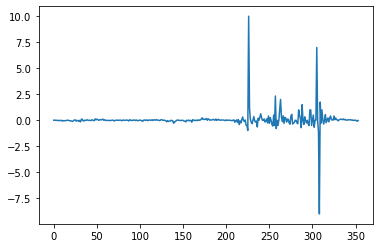

In [65]:
df['r_bill'] = compound_return(\
                    df_bill['Cumulative Return %'].shift(-1))
plt.plot(df['r_bill'])
df[['Dates','r_bill']].head()

To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bill` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1+ 0.007752) = (1 + 0.003876)(1 + r) \Rightarrow r = 0.003861$$
$$ (1 + 0.006460) = (1 + 0.003876)(1 + 0.003861)(1 + r) \Rightarrow r = -0.001282 $$



In [66]:
(df_bill['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.003876
2    1.007752
3    1.006460
4    1.001292
Name: Cumulative Return %, dtype: float64

In [67]:
1.006460/((1+0.003861)*(1+0.003876)) -1

-0.001282027007208475

## 3. Return Forecasts

After preprocessing available data is from 1991-03-29 to 2019-07-31

In [68]:
processed_df = df.loc[14:353].reset_index(drop=True)
processed_df.tail()

,Dates,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
335,2019-02-28,-3.780938,-0.000198,0.3123,1.16,1.0,1.0,1.0,1.0,1.0,1.0,0.083610,0.017924,0.027123,-0.109354,0.0240,-0.020833
336,2019-03-29,-3.785870,0.001741,0.0657,1.07,1.0,1.0,1.0,1.0,1.0,1.0,0.083278,0.039313,0.024157,0.035393,0.0235,0.012766
337,2019-04-30,-3.818848,0.004089,0.1212,1.01,1.0,1.0,1.0,1.0,1.0,1.0,0.075730,-0.065778,0.025012,-0.143651,0.0238,-0.033613
338,2019-05-31,-3.740195,0.003187,-0.1581,0.96,0.0,1.0,1.0,1.0,0.0,1.0,0.076963,0.068930,0.021419,-0.066997,0.0230,-0.095652
339,2019-06-28,-3.792573,0.000773,-0.0816,1.04,1.0,1.0,1.0,1.0,1.0,1.0,0.077539,0.013128,0.019984,0.010308,0.0208,-0.019231


### 3.1 Stock Returns

First step is to find truncated PCA for different number of eigenvalues.
<br>
PCA is implemented on the following matrix. Each variable corresponds to a set of observations and hence is a column vector.
<br>
[ $log(\frac{D}{P})$, Inflation, Term Spread, Default Spread, Output Gap, MA(1,12), MA(2,12), MOM(9), MOM(12) ] 
<br>

Second step is to come up with a decision rule on how to truncate eigenvalues.
The research paper utilizes (1) out-of-sample $R^2$ denoted as $R_{OS}^2$ and (2) Clark and West statistic.
<br>
where 
$$R_{OS}^2 = 1 - \frac{\sum_{t=1}^T (r_{t} - \widehat{r}_{t})}{\sum_{t=1}^T (r_{t} - \overline{r}_{t-1})} $$
and
<br>
<br>
$\widehat{r}_{t}$ is the fitted value using data up to t-1
<br>
$\overline{r}_{t-1}$ is the historal average using data upto t-1
<br>
<br>
Apart from $R_{OS}^2$, the paper utilizes Clark and West (2007) test. 
<br> Refer: Approximately Normal Tests for Equal Predictive Accuracy in Nested Models.
<br> Clark and West claims that test of mean squared prediction error (MSPE) typically exhibits a stylised pattern. That is, `the MSPE under Null (parsimonious model) is relatively smaller than it is expected to be because of the efficiency of parsimonious model and noises from estimating more parameters`. Therefore, authors propose an alternative hypothesis test as following:
<br>
For the hypothesis testing <br>H0: Parsimonious model (constant) MSPE is equal to or better than that of the larger model, H1: Larger model is better.
$$ \hat{f}_{t+1} = (y_{t+1} - \hat{y}_{\text{pars:} t,t+1})^2 - [(y_{t+1} - \hat{y}_{\text{large:} t,t+1})^2 - (\hat{y}_{\text{pars:} t,t+1} - \hat{y}_{\text{large:} t,t+1})^2] $$
$$ \overline{f} = \frac{1}{T}\sum_{t=1}^{T}\hat{f}_{t+1}$$
$$ s_{\hat{f}-\overline{f}}^2 = \frac{1}{T-1}\sum_{t=1}^{T}(\hat{f}_{t+1}-\overline{f})^2 $$

<br>Test statistics is: $$ CW = \frac{\overline{f}}{s_{\hat{f}-\overline{f}}/\sqrt{T}}$$ <br> the mean of $\hat{f}_{t+\tau}$ denoted as $\overline{\hat{f}_{t+\tau}}$ . With 10% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.282. With 5% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.645. For one step forecast errors, the usual least squares standard errors can be used. For autocorrelated forecast errors, an autocorrelation consistent standard error should be used.

In [69]:
def truncated_PC(X,dim):
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_X =  np.matmul(X,V[:,:dim])
    return approx_X

In [70]:
def PC_approx_error(X,dim):
    """
    PC approximation errors in terms of frobenius norms
    """
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_A =  np.matmul(np.matmul(V[:,:dim],
                            np.diag(eig[:dim])),
                            V[:,:dim].transpose())
    error = np.linalg.norm(approx_A - np.matmul(\
                                X.transpose(),X), ord='fro')
    return error

In [71]:
def PC_fit(X,r,dim):
    """
    estimates SPX Index return in a way that minimizes l2 norm
    """
    X = np.concatenate((np.ones(X.shape[0])
                        .reshape(-1,1),
                        X),
                       axis=1)
    beta = \
    np.matmul(
        np.linalg.inv(\
            1e-6*np.eye(dim+1) + np.matmul(X.transpose(),X)),
        np.matmul(X.transpose(),r))
    return beta

### 3.1.1 Principle Component Regression

In [72]:
stock_explanatory_variables = \
            ['log_DP','inflation','Term_Spread','Default_Spread',\
            'output_gap','MA_1_12','MA_2_12','MOM_9','MOM_12']
X = processed_df[stock_explanatory_variables].values

The plot of PC approximation errors in terms of frobenius norm is as following:

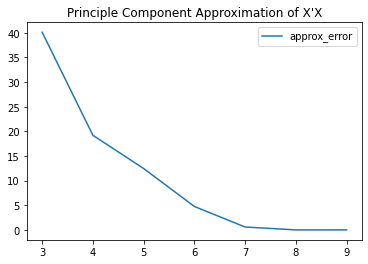

In [73]:
PC_plot_df = pd.DataFrame([])
PC_plot_df['dim'] = range(3,X.shape[1]+1) 
PC_plot_df['approx_error'] = [PC_approx_error(X,dim) for dim \
                               in range(3,X.shape[1]+1)]
plt.plot('dim','approx_error',data=PC_plot_df)
plt.title("Principle Component Approximation of X'X")
plt.legend()

Above plot confirms that the principle component approximation works as expected

Following figures compare actual return with estimated return based on PC regression.

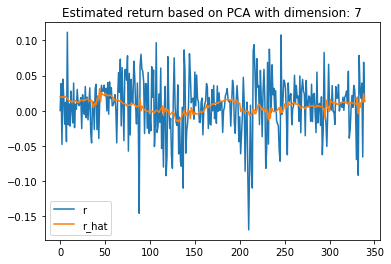

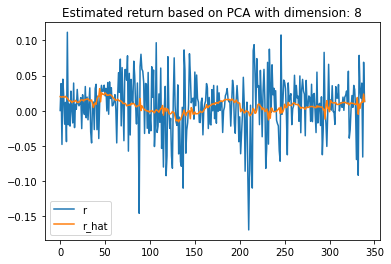

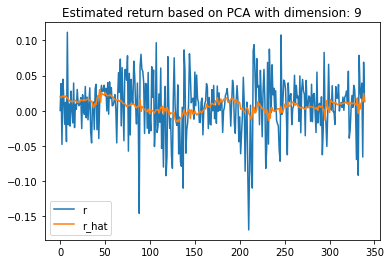

In [74]:
for i in range(7,10):
    dim = i
    r = processed_df['r_SPX'].values
    X_PCA = truncated_PC(X,dim)
    w = PC_fit(X_PCA,r,dim)
    X_PCA_intercept = np.concatenate(
                        (np.ones(X_PCA.shape[0])
                         .reshape(-1,1),
                         X_PCA),axis=1)
    r_hat = np.matmul(X_PCA_intercept,w)
    plt.figure(i)
    PC_plot_df2 = pd.DataFrame([])
    PC_plot_df2['r_hat'] = r_hat
    PC_plot_df2['r'] = r
    plt.plot('r',data=PC_plot_df2)
    plt.plot('r_hat',data=PC_plot_df2)
    plt.title(f'Estimated return based on PCA with dimension: {dim}')
    plt.legend()


### 3.1.2  $R_{OS}^2$ Computation

Following the logic of the original paper, I will compute $R_{OS}^2$ for monthly (h=1), quartherly (h=3), semi-annual (h=6), and annual (h=12). And out-of-sample forecasts are estimated by recursive estimation windows. For example, for monthly estimation, initial 200 samples are used exclusively for fitting the model. The 201$^{\text{st}}$ sample is forecasted by the model fitted by 200 samples. The 202$^{\text{nd}}$ sample is estimated by the model fitted using 201 samples. And so on.
<br>
<br>
Below illustrations show that monthly $R_{OS}^2$ gives the highest value range. This is consistent with the original paper. 

In [75]:
X[:200].shape

(200, 9)

In [76]:
def Rsquared_OS(X,r,dim,OS_start):
    """
    computes out-of-sample rsquared.
    First computes PCA only using explanatory variables 
    without augmenting the data with a constant = 1.
    For regression result, added a constant to capture 
    the y-intercept. 
    PCA_fit by default adds the constant column. 
    Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained 
    by the PCA_fit
    """
    numerator = 0
    denominator = 0
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim) 
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate(
            (np.ones(X_PCA_OS.shape[0])
             .reshape(-1,1),
             X_PCA_OS),
            axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        numerator += (r[i] - r_hat)**2
        denominator += (r[i]-r[:i].mean())**2
    R_squared_OS = 1 - numerator/(denominator + 1e-6)
    return R_squared_OS

### 3.1.2.1 Month $R_{OS}^2$ 

Text(0.5, 1.0, 'Month out-of-sample R-squared')

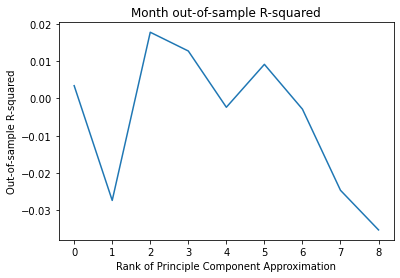

In [77]:
plt.plot([Rsquared_OS(X,r,i,200) for i in range(1,X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Month out-of-sample R-squared')

### 3.1.2.2  Quarter $R_{OS}^2$

For consistency, I utilized 66 quarterly observations exclusively for fitting the model. Following dataframe shows that 66$^{\text{th}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [78]:
(processed_df[2:].reset_index()
                 .set_index('Dates')
                 .resample('3M')
                 .agg('last')
                 .reset_index()[64:].head())

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
64,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,-0.017816,0.048994,0.025942,0.0460,0.017391
65,2007-08-31,197,-3.779418,0.001781,0.6221,0.86,1.0,1.0,1.0,1.0,1.0,1.0,0.018905,0.035794,0.045321,0.012886,0.0391,-0.048593
66,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
67,2008-02-29,203,-3.710938,0.003448,1.7002,1.29,0.0,0.0,1.0,1.0,0.0,0.0,0.009492,-0.005960,0.035102,-0.027862,0.0181,-0.248619
68,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,1.0,0.0,0.0,-0.008239,-0.085962,0.040653,-0.023442,0.0185,0.010811


Text(0.5, 1.0, 'Quarter out-of-sample R-squared')

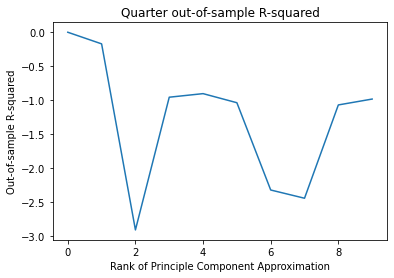

In [79]:
X_quarter = (processed_df[2:]
             .set_index('Dates')
             .resample('3M')
             .agg('last')[stock_explanatory_variables].values)
r_quarter = (processed_df[2:]
             .set_index('Dates')
             .resample('3M')
             .agg('last')['r_SPX'].values)
plt.plot([Rsquared_OS(X_quarter,r_quarter,i,66) 
          for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Quarter out-of-sample R-squared')

### 3.1.2.3  Semi-annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [80]:
(processed_df[2:].reset_index()
                 .set_index('Dates')
                 .resample('6M')
                 .agg('last')
                 .reset_index()[32:].head())

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
32,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,-0.017816,0.048994,0.025942,0.0460,0.017391
33,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
34,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,1.0,0.0,0.0,-0.008239,-0.085962,0.040653,-0.023442,0.0185,0.010811
35,2008-11-30,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,0.007822,0.029200,-0.295240,0.0001,10.000000
36,2009-05-31,218,-3.346824,0.001007,3.3204,2.52,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.137647,0.000196,0.034604,0.020894,0.0014,0.357143


Text(0.5, 1.0, 'Semi-annual out-of-sample R-squared')

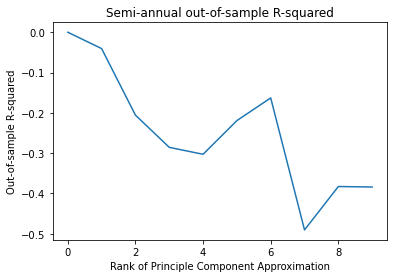

In [81]:
X_semi = (processed_df[2:]
          .set_index('Dates')
          .resample('6M')
          .agg('last')[stock_explanatory_variables].values)
r_semi = (processed_df[2:]
          .set_index('Dates')
          .resample('6M')
          .agg('last')['r_SPX'].values)
plt.plot([Rsquared_OS(X_semi,r_semi,i,33) 
          for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Semi-annual out-of-sample R-squared')

### 3.1.2.4  Annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [82]:
(processed_df.reset_index()
 .set_index('Dates')
 .resample('Y')
 .agg(lambda x: x[-2])
 .reset_index()[15:].head())

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
15,2006-12-31,188,-3.814893,-0.004438,-0.4390,0.87,1.0,1.0,1.0,1.0,1.0,1.0,0.006390,0.012616,0.044610,0.050482,0.0490,-0.002041
16,2007-12-31,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
17,2008-12-31,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,0.007822,0.029200,-0.295240,0.0001,10.000000
18,2009-12-31,224,-3.617410,0.003002,3.1402,1.13,1.0,1.0,1.0,-1.0,1.0,1.0,-0.077893,0.017771,0.032002,0.197863,0.0006,0.000000
19,2010-12-31,236,-3.755558,0.003482,2.6254,1.05,1.0,1.0,-1.0,1.0,1.0,1.0,-0.001713,0.065300,0.027954,0.176969,0.0017,-0.294118


c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Annual out-of-sample R-squared')

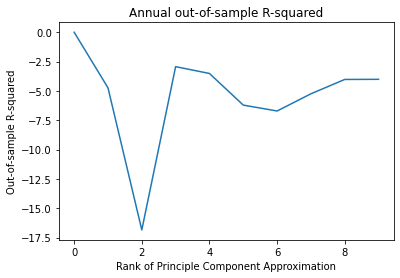

In [83]:
X_annual = (processed_df.set_index('Dates')
            .resample('Y')
            .agg(lambda x: x[-2])[stock_explanatory_variables]
            .values)
r_annual = (processed_df.set_index('Dates')
            .resample('Y')
            .agg(lambda x: x[-2])['r_SPX'].values)
plt.plot([Rsquared_OS(X_annual,r_annual,i,16) 
          for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Annual out-of-sample R-squared')

### 3.1.3  Clark and West(2007) Test Statistics Computation

In [84]:
def CW_test(X,r,dim,OS_start):
    """
    computes Clark and West test statistics.
    First computes PCA only using explanatory 
    variables without augmenting the data with 
    a constant = 1.
    For regression result, added a constant to 
    capture the y-intercept. 
    PCA_fit by default adds the constant column. 
    Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained 
    by the PCA_fit

    """
    denom = len(r) - OS_start
    num = []
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim)
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate(
            (np.ones(X_PCA_OS.shape[0])
             .reshape(-1,1),X_PCA_OS),axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        num += [(r[i]-r[:i].mean())**2 
                - (r[i] - r_hat)**2  
                + (r[:i].mean() - r_hat)**2]
    f_bar = np.array(num).mean()
    CW = np.sqrt(denom) * f_bar / \
         np.std(np.array(num) - f_bar,ddof=1)
    return CW

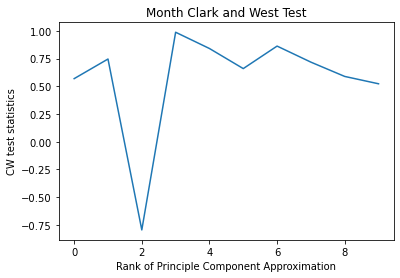

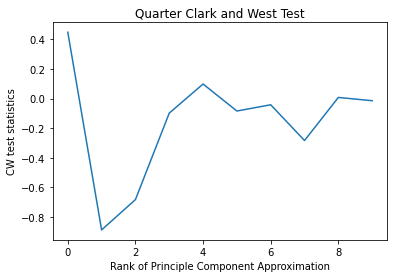

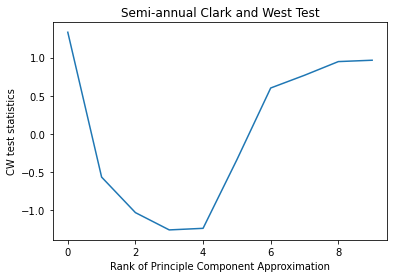

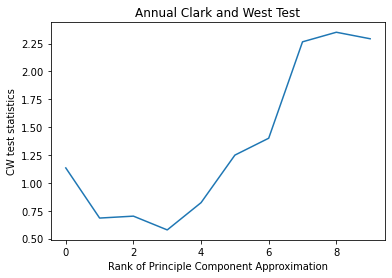

In [85]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Month Clark and West Test')
    else:
        eval(f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        if item == 'semi':
            plt.title(f'{item[0].upper()}{item[1:]}' + '-annual Clark and West Test')
        else:
            plt.title(f'{item[0].upper()}{item[1:]} Clark and West Test')
    i+=1

### 3.2 Bond Returns

The logic of this section is equivalent to the stock returns. First section deals with principal component, the second section the $R_{OS}^2$ and the third section the Clark West test statistics.

In [86]:
bonds_explanatory_variables = ['y_bond','inflation','Term_Spread','Default_Spread',\
                               'output_gap','MOMBY_6','MOMBY_12']
X = processed_df[bonds_explanatory_variables].values
r = processed_df['r_bond'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[bonds_explanatory_variables].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bond'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[bonds_explanatory_variables].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bond'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[bonds_explanatory_variables].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bond'].values)


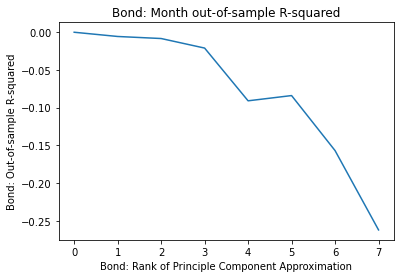

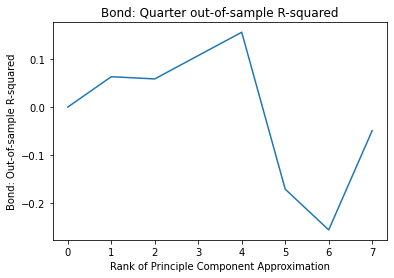

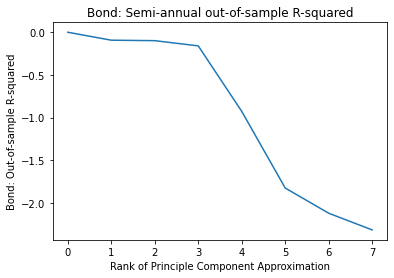

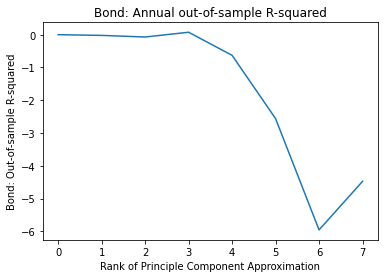

In [87]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([Rsquared_OS(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Bond: Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        plt.title('Bond: Month out-of-sample R-squared')
    else:
        eval(f'plt.plot([Rsquared_OS(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' + '-annual out-of-sample R-squared')
        else:
            plt.title('Bond: '+ f'{item[0].upper()}{item[1:]} out-of-sample R-squared')
    i+=1



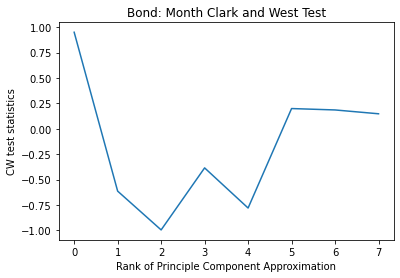

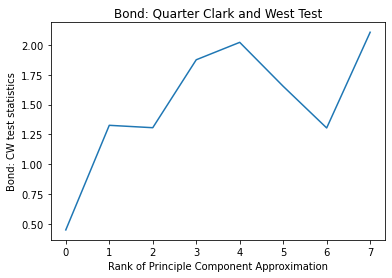

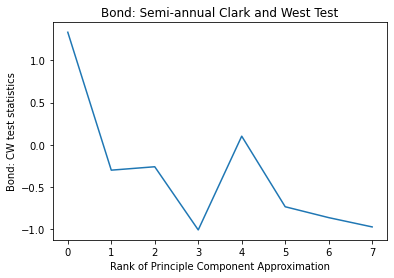

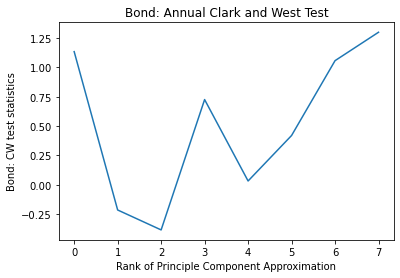

In [88]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) 
                  for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Bond: Month Clark and West Test')
    else:
        ev_str = f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item])'
        ev_str += 'for i in range(X.shape[1]+1)])'
        eval(ev_str)
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: CW test statistics')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' 
                      + '-annual Clark and West Test')
        else:
            plt.title('Bond: '+ 
                      f'{item[0].upper()}{item[1:]} Clark and West Test')
    i+=1

### 3.3 Bill Returns

The result is not as expected for bill returns. I suspect that the compound return data provided by the Factset is not accurate. For visualization of the data, Please refer to the next cell. The data shows the 1-month return. However, the maximum return was 10.0 and minimum value was -9. Clearly, return of -9 does not make sense. As I have checked the function I used to compute the return, I should find another source to obtain the return data. However, I do not currently know where I can retrieve the data.


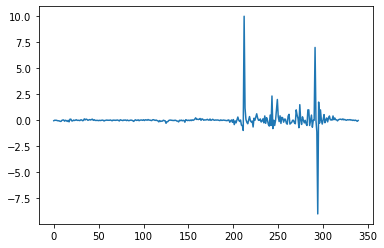

In [89]:
plt.plot( processed_df['r_bill'].values)

In [90]:
processed_df['r_bill'].values.min()

-8.999999999997765

In [91]:
X = processed_df['y_bill'].values.reshape(-1,1)
r = processed_df['r_bill'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[['y_bill']].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bill'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[['y_bill']].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bill'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[['y_bill']].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bill'].values)

In [92]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', Rsquared_OS(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",Rsquared_OS(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.009179932272639357
quarter  Rsquared_OS:  -0.10034942055336504
semi  Rsquared_OS:  -0.036215348588125584
annual  Rsquared_OS:  -0.025368552452170956


In [93]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', CW_test(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",CW_test(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.15740600529154802
quarter  Rsquared_OS:  -0.5358886092568652
semi  Rsquared_OS:  0.44965609947281726
annual  Rsquared_OS:  0.0908765054611409


## 4. Portfolio Performance Evaluation

Choice of the number of Principal Components for Month:
Stock: 7, Bond: 2

## 4.1 Return Estimate

In [94]:
r_actual = processed_df[['r_SPX','r_bond','r_bill']].values

In [95]:
r_hat_SPX = []
for i in range(r_actual.shape[0]):
    X_stock_PCA = truncated_PC(
            processed_df[stock_explanatory_variables][:i].values,7)
    w_stock = PC_fit(X_stock_PCA,r_actual[:i,0],7)
    x_stock_PCA_new = \
        np.concatenate(
            (np.ones(1),
             truncated_PC(
                 processed_df
                 [stock_explanatory_variables][:i+1]
                 .values,7)[-1,:]))
    r_hat_SPX+=[np.dot(x_stock_PCA_new,w_stock)]

No handles with labels found to put in legend.


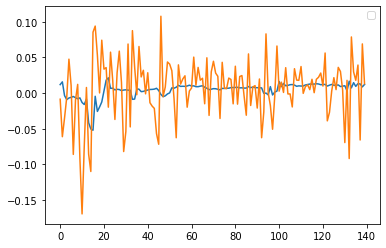

In [96]:
plt.plot(r_hat_SPX[200:])
plt.plot(r_actual[200:,0])
plt.legend()

In [97]:
r_hat_bond = []
for i in range(r_actual.shape[0]):
    X_bond_PCA = truncated_PC(
        processed_df
        [bonds_explanatory_variables][:i].values,2)
    w_bond = PC_fit(X_bond_PCA,r_actual[:i,1],2)
    x_bond_PCA_new = \
      np.concatenate(
        (np.ones(1),
         truncated_PC(
             processed_df
             [bonds_explanatory_variables][:i+1].values,2)[-1,:]))
    r_hat_bond+=[np.dot(x_bond_PCA_new,w_bond)]

No handles with labels found to put in legend.


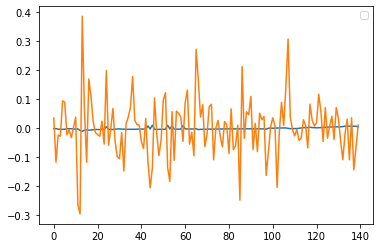

In [98]:
plt.plot(r_hat_bond[200:])
plt.plot(r_actual[200:,1])
plt.legend()

In [99]:
r_hat_bill = []
X_bill = np.concatenate((np.ones(r_actual.shape[0]).reshape(-1,1),
                         processed_df['y_bill'].values.reshape(-1,1)),axis=1)
for i in range(r_actual.shape[0]):
    w_bill = np.matmul(
                    np.matmul(
                        np.linalg.inv(1e-6*np.eye(2) + np.matmul(
                            X_bill[:i-1,:].transpose(),X_bill[:i-1,:])),
                            X_bill[:i-1,:].transpose()),
                        r_actual[:i-1,2])
    r_hat_bill+=[np.dot(X_bill[i-1,:],w_bill)]
    
    
    

No handles with labels found to put in legend.


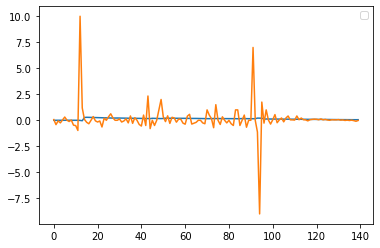

In [100]:
plt.plot(r_hat_bill[200:])
plt.plot(r_actual[200:,2])
plt.legend()

In [101]:
r_hat = pd.DataFrame(r_hat_SPX,columns = ['r_hat_SPX'])
r_hat['r_hat_bond'] = pd.Series(r_hat_bond)
r_hat['r_hat_bill'] = pd.Series(r_hat_bill)
r_hat = r_hat.astype(float)

c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\pandas\core\dtypes\cast.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


## 4.2 EWMA Covariance Estimate

I referred the formula of Exponentially Weighted Moving Average from Table 5.1 of Riskmetrics - technical document. It is as following:
$$Cov(r^i, r^j)= (1-\lambda)\sum_{t=0}^{T-1}\lambda^t (r_{t}^{i}-\overline{r}_{t}^{i})(r_{t}^{j}-\overline{r}_{t}^{j}) \quad i,j \in{\{stock, bond, bill\}}$$
The way I compute this amount is:
$$ X =\begin{pmatrix}
r^{stock}_0 -\overline{r}^{stock}& r^{bond}_0  -\overline{r}^{bond}& r^{bill}_0 -\overline{r}^{bill}\\ 
r^{stock}_1 -\overline{r}^{stock}&  r^{bond}_1 -\overline{r}^{bond}& r^{bill}_1 -\overline{r}^{bill}\\ 
r^{stock}_3 -\overline{r}^{stock}&  r^{bond}_2 -\overline{r}^{bond}& r^{bill}_2 -\overline{r}^{bill}
\end{pmatrix} \\
\Rightarrow
\tilde{X}=\sqrt{1-\lambda}\bigl(\begin{smallmatrix}
1 & 0 & 0\\ 
 0&  \lambda^{0.5}& 0\\ 
 0&  0& \lambda
\end{smallmatrix}\bigr)X = (\tilde{r}^{stock},\tilde{r}^{bond},\tilde{r}^{bill} )
\\
$$

$$\Rightarrow
\tilde{X}^T\tilde{X} = \begin{pmatrix}
 (\tilde{r}^{stock})^T\tilde{r}^{stock}& (\tilde{r}^{stock})^T\tilde{r}^{bond} &(\tilde{r}^{stock})^T\tilde{r}^{bill} \\ 
 (\tilde{r}^{bond})^T\tilde{r}^{stock}&  (\tilde{r}^{bond})^T\tilde{r}^{bond}& (\tilde{r}^{bond})^T\tilde{r}^{bill}\\ 
 (\tilde{r}^{bill})^T\tilde{r}^{stock}&  (\tilde{r}^{bill})^T\tilde{r}^{bond}& (\tilde{r}^{bill})^T\tilde{r}^{bill}
\end{pmatrix}
$$
which is the desired matrix

In [102]:
def EWMA(t):
    decay = 0.94
    A = np.matmul(np.diag([np.sqrt((1-decay)*decay**i) 
                           for i in range(t+1)]),r_actual[:t+1])
    return np.matmul(A.T,A)

In [103]:
EWMA(200)

array([[ 0.00119016, -0.00066904, -0.00047128],
       [-0.00066904,  0.00164213,  0.00131968],
       [-0.00047128,  0.00131968,  0.00323162]])

## 4.3 Black Litterman $\mu$ and $\Sigma$

### 4.3.1 Covariance Matrix of Active Views

$$\omega_{j} = \left( \frac{1-c_{j}}{c_{j}} \right)p_{j}\hat{\Sigma}_{t:t+h}p_{j}^{T}\quad \text{for} \space j = \text{stock, bond, or bill}$$
where $p_{stock}, p_{bond}, p_{bill}$ are first, second and third rows of $P = I_{3}$. And, $c_{stock} = 0.75, c_{bond} = 0.50, c_{bill} = 0.25$. Note that larger the c is, less relevant is the investor view and when c equals 1 then investor view is considered majestic. The rationale for the choice of parameter is that if regression result is credit-worthy (characterized by high $R^2_{OS}$) then do not utilize information about views.

I slightly modify the weights `c` because of poor quality of bond/bill returns data I obtained.

In [104]:
omega_stock = [(1/0.75 -1)*EWMA(t)[0,0] 
               for t in range(r_actual.shape[0])]
omega_bond  = [(1/0.5 -1)*EWMA(t)[1,1] 
               for t in range(r_actual.shape[0])]
omega_bill  = [(1/0.25 -1)*EWMA(t)[2,2] 
               for t in range(r_actual.shape[0])]

In [105]:
Omega = []
for i in range(len(omega_stock)):
    Omega += [np.diag([omega_stock[i],omega_bond[i],omega_bill[i]])]

### 4.3.2 $\mu_{BL}$ And $\Sigma_{BL}$

$$\mu_{BL} = \mu + \hat{\Sigma} P^T(P\hat{\Sigma}P^T+\Omega)^{-1}(V-P \mu) $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}P^T(P\hat{\Sigma}P^T+\Omega)^{-1}P\hat{\Sigma}$$

Da Silva(2009) claims that Black-Litterman was derived under the mean-variance portfolio optimization rather than optimizing the common active management performance measure, the information ratio. And, this resulted in a bias that could lead to unintentional trades.

The authors' remedy for this issue pertains to the practice of obtaining implied equilibrium excess returns through $\mu = \gamma \Sigma \omega_B$ where $\gamma$ is a risk-aversion coefficient. The author asserts to set $\mu = 0$. And, $\hat{r}$ is considered to be the active views $V$ and $P$ is assumed to be $I_3$.
In summary,
$$\mu_{BL} = \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{r} $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{\Sigma}$$

In [106]:
mu_BL = []
Sigma_BL = []
for i in range(len(r_actual)):
    mu_BL+=[np.dot(
                np.matmul(EWMA(i),
                    np.linalg.inv(
                        1e-6 + EWMA(i) + Omega[i])),
                r_hat.values[i] )]
    Sigma_BL+=[EWMA(i)
               -np.matmul(
                   np.matmul(
                       EWMA(i),
                       np.linalg.inv(
                           1e-6 +EWMA(i)+Omega[i]))
                   ,EWMA(i))]

### 4.3.3 Black-Litterman Return Expectation and Variance

$Return|view \sim N(\mu_{BL},\Sigma_{BL}) \\ \Rightarrow E[P^i_{t}] = P^i_{0}exp\left(\mu_{BL,i} + \frac{1}{2} \Sigma_{BL,(i,i)}\right) \quad \text{where} \quad i\in{\{stock,bond,bill\}}
 \\ \quad Cov[P^i_{t},P^j_{t}] =P^i_{0}P^i_{0}e^{\mu_{BL,i}+\mu_{BL,j}}e^{\frac{1}{2}\left(\Sigma_{BL,(ii)} +   \Sigma_{BL,(jj)}\right)}\bigodot\left(e^{\Sigma_{BL,(ij)}-1}\right)       $


In [107]:
m=[]
S=[]
for i in range(len(r_actual)):
    m += [np.exp(mu_BL[i]
          +0.5*np.diag(Sigma_BL[i]))
                  .reshape(-1,1)
          - 1]
    S += [np.multiply(
            np.matmul(
                np.exp(
                    mu_BL[i]
                    +0.5*np.diag(Sigma_BL[i]))
                     .reshape(-1,1),
                np.exp(
                    mu_BL[i]
                    +0.5*np.diag(Sigma_BL[i]))
                     .reshape(-1,1).T)
            ,np.exp(Sigma_BL[i]) - 1)]

### 4.3.4 DAA Portfolio Optimization

Initial attempt:

Optimization problem is:


\begin{aligned}
\max_{w} \quad & \left ( w-w_{bench} \right )^Tm\\
\textrm{s.t.} \quad & \left \| R\left ( w-w_{bench} \right )\right \|_2^2 \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}

where $R$ is the Cholesky Decomposition of $S$


In [108]:
def cholesky(A):
    """
    computes left cholesky matrix. Advantage of this 
    matrix over np.linalg.cholesky
    is that first few observation of S matrix is not 
    positive definite which creates
    an error message.
    """
    L = np.eye(3)
    L[1:,0]=-A[1:,0]/A[0,0]
    tmp = np.matmul(L,A)
    L2 = np.eye(3)
    L2[2,1] = -tmp[2,1]/tmp[1,1]
    diag = np.sqrt(np.matmul(
                    np.matmul(np.matmul(L2,tmp),L.T),L2.T))
    Linv=np.eye(3)
    Linv[1:,0] = -L[1:,0]/L[0,0]
    L2inv=np.eye(3)
    L2inv[2,1] = -L2[2,1]/L2[1,1]
    Left = np.matmul(np.matmul(Linv,L2inv),diag)
    return Left

Sanity Check:

In [109]:
R = cholesky(S[20]).T
R.T - np.linalg.cholesky(S[20])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.33680869e-19, 0.00000000e+00, 0.00000000e+00]])

In [110]:
for i in range(len(r_actual))[:5]:
    print(cholesky(S[i]))

[[ 5.32797217e-05  0.00000000e+00  0.00000000e+00]
 [-5.73580103e-04  2.58327850e-07  0.00000000e+00]
 [-6.21356947e-03  2.69271475e-05  4.56954959e-06]]
[[      nan 0.              nan]
 [      nan 0.0007352       nan]
 [      nan 0.0078131       nan]]
[[ 0.00785924  0.          0.        ]
 [-0.000789    0.00282752  0.        ]
 [ 0.00037972  0.00165482  0.00759579]]
[[ 0.00665097  0.          0.        ]
 [-0.00130537  0.00472013  0.        ]
 [ 0.00032736  0.00192706  0.00942859]]
[[ 9.86134023e-03  0.00000000e+00  0.00000000e+00]
 [-1.12425170e-03  5.44386103e-03  0.00000000e+00]
 [ 2.50735629e-05  4.10705348e-03  7.23005633e-03]]


c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


S is not psd for many observations. So I avoided cholesky

\begin{aligned}
\max_{w} \quad &  w^Tm\\
\textrm{s.t.} \quad &  \left ( w-w_{bench} \right )^TS\left ( w-w_{bench} \right ) \ \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}

To get constraints, I use fstring with list comprehension as below:

In [111]:
cone = '+'.join([f'((w{i}-w_bench[{i}])*S[i][{i},{j}]*(w{j}-w_bench[{j}]))'\
                 for i in range(3) for j in range(3)])
cone

'((w0-w_bench[0])*S[i][0,0]*(w0-w_bench[0]))+((w0-w_bench[0])*S[i][0,1]*(w1-w_bench[1]))+((w0-w_bench[0])*S[i][0,2]*(w2-w_bench[2]))+((w1-w_bench[1])*S[i][1,0]*(w0-w_bench[0]))+((w1-w_bench[1])*S[i][1,1]*(w1-w_bench[1]))+((w1-w_bench[1])*S[i][1,2]*(w2-w_bench[2]))+((w2-w_bench[2])*S[i][2,0]*(w0-w_bench[0]))+((w2-w_bench[2])*S[i][2,1]*(w1-w_bench[1]))+((w2-w_bench[2])*S[i][2,2]*(w2-w_bench[2]))'

In [112]:
w_LB = 0.05*np.ones(3)
w_bench = np.array([0.65,0.3,0.05])
TE=0.02
w = np.array([np.nan,np.nan,np.nan]).reshape(-1,3)
for i in range(len(r_actual)):
    # Create a new model

        model = Model("qcp")
        model.setParam('OutputFlag', 0)
        # Create variables
        w0 = model.addVar(name="w0")
        w1 = model.addVar(name="w1")
        w2 = model.addVar(name="w2")

        # Set objective: x
        obj = m[i][0][0]*w0 + m[i][1][0]*w1 + m[i][2][0]*w2 
        model.setObjective(obj, GRB.MAXIMIZE)

        model.addConstr(w0 + w1 + w2 == 1, "c0")
        model.addConstr(w0  >= w_LB[0], "c1")
        model.addConstr(w1  >= w_LB[1], "c2")
        model.addConstr(w2  >= w_LB[2], "c3")

        # Add second-order cone: 
        eval('model.addConstr(' + cone + '<= (TE**2 *(1/12)), "qc0")')
        model.optimize()

        if i%100==0:
            print(f'{i}th observation: ')
            for v in model.getVars():
                print('%s %g' % (v.varName, v.x))
            print('Obj: %g' % obj.getValue())
        w = np.concatenate((w,np.array([model.getVars()[i].x 
                                for i in range(3)]).reshape(-1,3)))
w = w[1:,:]

Using license file C:\Users\dkim8\gurobi.lic
Academic license - for non-commercial use only
0th observation: 
w0 0.0500041
w1 0.0500182
w2 0.899978
Obj: 0.00750459
100th observation: 
w0 0.818146
w1 0.131795
w2 0.050059
Obj: 0.00521479
200th observation: 
w0 0.817996
w1 0.132002
w2 0.0500014
Obj: 0.00682026
300th observation: 
w0 0.700523
w1 0.131539
w2 0.167938
Obj: 0.0127552


In [113]:
weights_df = pd.DataFrame(w)
weights_df['Dates'] = processed_df['Dates']
weights_df.columns = ['w_stock','w_bond','w_bill','Dates']

Text(0.5, 1.0, 'DAA stock weight')

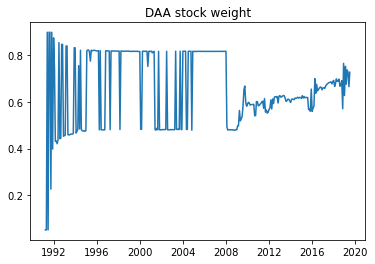

In [114]:
plt.plot('Dates','w_stock',data=weights_df)
plt.title("DAA stock weight")

Text(0.5, 1.0, 'DAA bond weight')

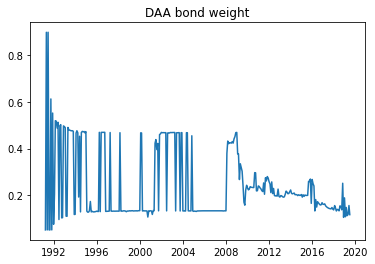

In [115]:
plt.plot('Dates','w_bond',data=weights_df)
plt.title("DAA bond weight")

Text(0.5, 1.0, 'DAA bill weight')

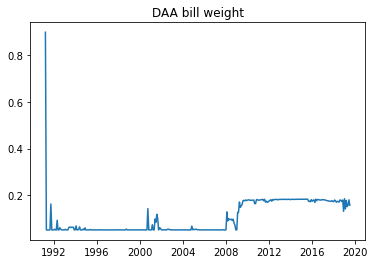

In [116]:
plt.plot('Dates','w_bill',data=weights_df)
plt.title("DAA bill weight")

### 4.3.5 Portfolio Performance Statistics

### 4.3.5.1 Annualized Return

Below cell tries to adjusts for erratic data. Bill return is not expected to change by 500% over a month.

In [117]:
np.place(w[:,2], np.abs(r_actual[:,2])>5, 0)
w[np.abs(r_actual[:,2])>5]

array([[0.48131974, 0.46832747, 0.        ],
       [0.61944122, 0.19848678, 0.        ],
       [0.56876536, 0.25783327, 0.        ]])

In [118]:
r_portfolio_actual = np.multiply(r_actual,w).sum(axis=1)
r_portfolio_bench = np.multiply(r_actual,w_bench).sum(axis=1)

In [119]:
DAA_geo_return = ((((r_portfolio_actual[200:]+1)
                   .prod()**(1/r_portfolio_actual[200:].shape[0]))
                  -1) * 12)
DAA_geo_return

0.1278717396301543

In [120]:
Bench_geo_return =(((r_portfolio_bench[200:]+1).prod()**(1/r_portfolio_bench[200:].shape[0]))-1) * 12
Bench_geo_return 

0.0824949523121612

Annualized geometric return of DAA portfolio from November 2007 (observation index 200) to July is 13.97% and that of benchmark portfolio is 7.49%

### 4.3.5.2 Standard Deviation

In [121]:
DAA_std = r_portfolio_actual[200:].std(ddof=1)
DAA_std

0.09425848480403445

In [122]:
Bench_std = r_portfolio_bench[200:].std(ddof=1)
Bench_std

0.0772344189520475

### 4.3.5.3 Maximum Drawdown

In [123]:
DAA_mdd = 1-(r_portfolio_actual[200:] + 1).cumprod().min()
DAA_mdd

0.5052443383643339

In [124]:
Bench_mdd = 1-(r_portfolio_bench[200:] + 1).cumprod().min()
Bench_mdd

0.4146251668854053

### 4.3.5.4 Calmar Ratio

In [125]:
DAA_Calmar = DAA_geo_return/DAA_mdd
DAA_Calmar 

0.25308891148414103

In [126]:
Bench_Calmar = Bench_geo_return/Bench_mdd
Bench_Calmar

0.198962723203344

### 4.3.5.4 Average Excess Return

In [127]:
Avg_Excess_Return = DAA_geo_return - Bench_geo_return
Avg_Excess_Return

0.045376787317993106

### 4.3.5.5 Tracking Error

In [128]:
Tracking_Error = ((r_portfolio_actual[200:] 
                  - r_portfolio_bench[200:])
                 .std(ddof=1) *np.sqrt(12))
Tracking_Error

0.30946774771592317

### 4.3.5.6 Information Ratio

In [129]:
IR = Avg_Excess_Return/Tracking_Error
IR

0.14662848601479098

### 4.3.5.7 CER Gain

Certainty Equivalent Return is the return an investor would want to be guaranteed for his investment. The investor is assumed to have power utility with risk aversion coefficients of two. This means the investor is risk-averse because utility function is concave.
Power Utility fuction is as following:
$$U(x) = \frac{x^{1-RAA}}{1-RAA}$$
To compute the CER, for each return observation, compute $U(1+return)$. Denote the average of the return as $\overline{U}$
Then, we recover CER from the following equation.
$$ \overline{U} = \frac{\left(1 + CER\right)^{1-RAA}}{1-RAA}$$
For the ease of writing code, this is equivalent to:
$$ CER = [\left(1-RRA \right)\overline{U} ]^{\frac{1}{1-RAA}} -1 $$
As the final step, the return is annualized.

In [130]:
U_bar_actual = (-(1+r_portfolio_actual)**(-1)).mean()
U_bar_bench = (-(1+r_portfolio_bench)**(-1)).mean()

In [131]:
CER_actual = ((-U_bar_actual)**(-1) -1)*12
CER_bench = ((-U_bar_bench)**(-1) -1)*12

In [132]:
CER_gain = CER_actual - CER_bench
CER_gain

0.015038426261668292

## 4.4 Transaction Cost and Performance Evaluation

### 4.4.1 Transaction Cost

In [133]:
transaction_cost = np.arange(0,0.0455,0.0005) # 50 basis points increments
transaction_cost

array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 , 0.0235,
       0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275,
       0.028 , 0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315,
       0.032 , 0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355,
       0.036 , 0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395,
       0.04  , 0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435,
       0.044 , 0.0445, 0.045 ])

In [134]:
r_sign = np.sign(r_portfolio_actual)

In [135]:
transaction_df = processed_df[['Dates']]
transaction_df['tc_0_bp'] = r_portfolio_actual 
for i in range(1,len(transaction_cost)):
    string = f'transaction_df["tc_{i*50}_bp"] = np.multiply(r_portfolio_actual,'
    string += '(1-r_sign*transaction_cost[i]))'
    exec(string)
transaction_df.set_index('Dates', inplace=True)

c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
transaction_df.head()

,tc_0_bp,tc_50_bp,tc_100_bp,tc_150_bp,tc_200_bp,tc_250_bp,tc_300_bp,tc_350_bp,tc_400_bp,tc_450_bp,...,tc_4050_bp,tc_4100_bp,tc_4150_bp,tc_4200_bp,tc_4250_bp,tc_4300_bp,tc_4350_bp,tc_4400_bp,tc_4450_bp,tc_4500_bp
Dates,,,,,,,,,,,,,,,,,,,,,
1991-03-29,-0.036231,-0.036249,-0.036267,-0.036285,-0.036303,-0.036321,-0.036340,-0.036358,-0.036376,-0.036394,...,-0.037698,-0.037716,-0.037734,-0.037753,-0.037771,-0.037789,-0.037807,-0.037825,-0.037843,-0.037861
1991-04-30,0.006605,0.006602,0.006598,0.006595,0.006592,0.006589,0.006585,0.006582,0.006579,0.006575,...,0.006338,0.006334,0.006331,0.006328,0.006324,0.006321,0.006318,0.006314,0.006311,0.006308
1991-05-31,-0.041896,-0.041917,-0.041938,-0.041959,-0.041980,-0.042001,-0.042022,-0.042043,-0.042064,-0.042085,...,-0.043593,-0.043614,-0.043635,-0.043656,-0.043677,-0.043698,-0.043719,-0.043740,-0.043761,-0.043782
1991-06-28,-0.002216,-0.002217,-0.002218,-0.002220,-0.002221,-0.002222,-0.002223,-0.002224,-0.002225,-0.002226,...,-0.002306,-0.002307,-0.002308,-0.002309,-0.002310,-0.002312,-0.002313,-0.002314,-0.002315,-0.002316
1991-07-31,0.013559,0.013552,0.013545,0.013538,0.013531,0.013525,0.013518,0.013511,0.013504,0.013497,...,0.013009,0.013003,0.012996,0.012989,0.012982,0.012975,0.012969,0.012962,0.012955,0.012948


In [137]:
r_sign_bench = np.sign(r_portfolio_bench)

transaction_benchmark_df = processed_df[['Dates']]
transaction_benchmark_df['tc_0_bp'] = r_portfolio_bench 
for i in range(1,len(transaction_cost)):
    string = f'transaction_benchmark_df["tc_{i*50}_bp"]'
    string += '=np.multiply(r_portfolio_bench,'
    string += '(1-r_sign_bench*transaction_cost[i]))'
    exec(string)
transaction_benchmark_df.set_index('Dates', inplace=True)

c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\dkim8\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
transaction_benchmark_df.head()

,tc_0_bp,tc_50_bp,tc_100_bp,tc_150_bp,tc_200_bp,tc_250_bp,tc_300_bp,tc_350_bp,tc_400_bp,tc_450_bp,...,tc_4050_bp,tc_4100_bp,tc_4150_bp,tc_4200_bp,tc_4250_bp,tc_4300_bp,tc_4350_bp,tc_4400_bp,tc_4450_bp,tc_4500_bp
Dates,,,,,,,,,,,,,,,,,,,,,
1991-03-29,-0.002896,-0.002898,-0.002899,-0.002901,-0.002902,-0.002904,-0.002905,-0.002906,-0.002908,-0.002909,...,-0.003014,-0.003015,-0.003016,-0.003018,-0.003019,-0.003021,-0.003022,-0.003024,-0.003025,-0.003027
1991-04-30,0.026753,0.026740,0.026726,0.026713,0.026700,0.026686,0.026673,0.026659,0.026646,0.026633,...,0.025670,0.025656,0.025643,0.025629,0.025616,0.025603,0.025589,0.025576,0.025563,0.025549
1991-05-31,-0.024340,-0.024352,-0.024364,-0.024377,-0.024389,-0.024401,-0.024413,-0.024425,-0.024437,-0.024450,...,-0.025326,-0.025338,-0.025350,-0.025362,-0.025375,-0.025387,-0.025399,-0.025411,-0.025423,-0.025435
1991-06-28,0.027612,0.027598,0.027584,0.027571,0.027557,0.027543,0.027529,0.027515,0.027502,0.027488,...,0.026494,0.026480,0.026466,0.026452,0.026439,0.026425,0.026411,0.026397,0.026383,0.026369
1991-07-31,-0.002939,-0.002941,-0.002942,-0.002943,-0.002945,-0.002946,-0.002948,-0.002949,-0.002951,-0.002952,...,-0.003058,-0.003060,-0.003061,-0.003062,-0.003064,-0.003065,-0.003067,-0.003068,-0.003070,-0.003071


### 4.4.2 Performance Evaluation

### 4.4.2.1 Annualized Return

In [139]:
tc_perf_df = pd.DataFrame([f'{i*50} bp' 
                           for i in range(0,len(transaction_cost))])
tc_perf_df.columns=['transaction_cost']

In [140]:
tc_return = []
tc_bench_return = []
for i in range(0,len(transaction_cost)):
    string = f"tc_return += [(((transaction_df"
    string += f"['tc_{i*50}_bp'].values[200:]+1)"
    string += f'.prod()**(1/transaction_df["tc_'
    string += f'{i*50}_bp"].values[200:].shape[0]))-1) * 12]'
    exec(string)
    string2 = f"tc_bench_return += [(((transaction_"
    string2 += f"benchmark_df['tc_{i*50}_bp'].values[200:]+1)"
    string2 += f'.prod()**(1/transaction_benchmark_df'
    string2 += f'["tc_{i*50}_bp"].values[200:].shape[0]))-1) * 12]'
    exec(string2)

In [141]:
tc_perf_df['annual_return'] = tc_return
tc_perf_df['annual_return_bench'] = tc_bench_return

In [142]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench
0,0 bp,0.127872,0.082495
1,50 bp,0.127481,0.082196
2,100 bp,0.127091,0.081897
3,150 bp,0.126701,0.081598
4,200 bp,0.126310,0.081300


### 4.4.2.2 Standard Deviation

In [143]:
aug_str = '.values[200:].std(ddof=1)'
tc_perf_df['std'] = [eval(f'transaction_df["tc_{i*50}_bp"]'+aug_str)
                            for i in range(0,len(transaction_cost))]

In [144]:
tc_perf_df['std_bench'] = \
[eval(f'transaction_benchmark_df["tc_{i*50}_bp"]'+aug_str)
      for i in range(0,len(transaction_cost))]

In [145]:
tc_perf_df[['transaction_cost','std_bench']].head()

,transaction_cost,std_bench
0,0 bp,0.077234
1,50 bp,0.077230
2,100 bp,0.077226
3,150 bp,0.077221
4,200 bp,0.077217


### 4.4.2.3 Maximum Drawdown

In [146]:
aug_str = '.values[200:]+1).cumprod().min()'
tc_perf_df['max_drawdown'] = \
[eval(f'1-(transaction_df["tc_{i*50}_bp"]'+aug_str)
      for i in range(0,len(transaction_cost))]

In [147]:
tc_perf_df['max_drawdown_bench'] = \
[eval(f'1-(transaction_benchmark_df["tc_{i*50}_bp"]'+aug_str)
      for i in range(0,len(transaction_cost))]

In [148]:
tc_perf_df[['transaction_cost','max_drawdown',\
            'max_drawdown_bench']].head()

,transaction_cost,max_drawdown,max_drawdown_bench
0,0 bp,0.505244,0.414625
1,50 bp,0.505500,0.414861
2,100 bp,0.505755,0.415096
3,150 bp,0.506010,0.415332
4,200 bp,0.506265,0.415567


### 4.4.2.4 Calmar Ratio

In [149]:
tc_perf_df['calmar'] =\
    tc_perf_df['annual_return'].values/ \
    tc_perf_df['max_drawdown'].values

In [150]:
tc_perf_df['calmar_bench'] = \
    tc_perf_df['annual_return_bench'].values/ \
    tc_perf_df['max_drawdown_bench'].values

In [151]:
tc_perf_df[['transaction_cost','calmar','calmar_bench']].head()

,transaction_cost,calmar,calmar_bench
0,0 bp,0.253089,0.198963
1,50 bp,0.252189,0.198129
2,100 bp,0.251290,0.197297
3,150 bp,0.250391,0.196466
4,200 bp,0.249494,0.195635


### 4.4.2.5 Average Excess Return

In [152]:
tc_perf_df['avg_excess_return'] =\
tc_perf_df['annual_return'] - tc_perf_df['annual_return_bench']

In [153]:
tc_perf_df[['transaction_cost','avg_excess_return']].head()

,transaction_cost,avg_excess_return
0,0 bp,0.045377
1,50 bp,0.045285
2,100 bp,0.045194
3,150 bp,0.045102
4,200 bp,0.045010


### 4.4.2.6 Tracking Error

In [154]:
string = f'(transaction_df["tc_{i*50}_bp"].values[200:] '
string += f'- transaction_benchmark_df["tc_{i*50}_bp"]'
string += '.values[200:]).std(ddof=1)*np.sqrt(12)'
tc_perf_df['tracking_error'] = \
[eval(string) for i in range(0,len(transaction_cost))]

In [155]:
tc_perf_df[['transaction_cost','tracking_error']].head()

,transaction_cost,tracking_error
0,0 bp,0.304416
1,50 bp,0.304416
2,100 bp,0.304416
3,150 bp,0.304416
4,200 bp,0.304416


### 4.4.2.7 Information Ratio

In [156]:
tc_perf_df['IR'] = \
    tc_perf_df['avg_excess_return'].values/ \
    tc_perf_df['tracking_error'].values

In [157]:
tc_perf_df[['transaction_cost','IR']].head()

,transaction_cost,IR
0,0 bp,0.149062
1,50 bp,0.148761
2,100 bp,0.148460
3,150 bp,0.148159
4,200 bp,0.147859


### 4.4.2.7 CER Gain

In [158]:
cer_gain=[]
for i in range(transaction_df.shape[1]):
    string = f'transaction_df["tc_{i*50}_bp"].values[200:]'
    string2=f'transaction_benchmark_df["tc_{i*50}_bp"].values[200:]'
    exec(f'U_bar_tc = (-(1+{string})**(-1)).mean()')
    exec(f'U_bar_bench_tc = (-(1+ {string2})**(-1)).mean()')
    CER_actual_tc = ((-U_bar_tc)**(-1) -1)*12
    CER_bench_tc = ((-U_bar_bench_tc)**(-1) -1)*12
    cer_gain += [CER_actual_tc-CER_bench_tc]
tc_perf_df['CER_gain'] = cer_gain

### 4.4.3 Plot

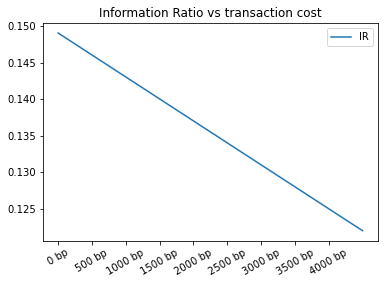

In [159]:
plt.plot('transaction_cost','IR',data=tc_perf_df)
plt.title('Information Ratio vs transaction cost')
plt.xticks(np.arange(0,90,10),rotation=30)
plt.legend()

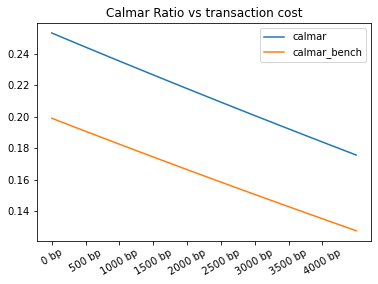

In [160]:
plt.plot('transaction_cost','calmar',data=tc_perf_df)
plt.plot('transaction_cost','calmar_bench',data=tc_perf_df)
plt.title('Calmar Ratio vs transaction cost')
plt.xticks(np.arange(0,90,10),rotation=30)
plt.legend()

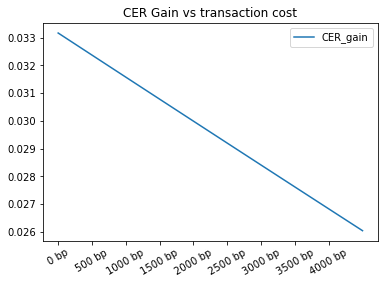

In [161]:
plt.plot('transaction_cost','CER_gain',data=tc_perf_df)
plt.title('CER Gain vs transaction cost')
plt.xticks(np.arange(0,90,10),rotation=30)
plt.legend()

## 5. Data Export

Exporting data to csv

In [164]:
weights_df.to_csv('weight.csv')

## 6. Simple Robust Allocation

### 6.1 Optimization

\begin{aligned}
\max_{w} \quad &  \min_{m \in \hat{\theta}_{m}} \left(w-w_{bench} \right)^T m\\
\textrm{s.t.} \quad &  \left ( w-w_{bench} \right )^TS\left ( w-w_{bench} \right ) \ \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}

where $$\hat{\theta}_m\equiv \{m:  \left ( m-\mu_{BL} \right )^T \Sigma_{BL}^{-1} \left ( m-\mu_{BL} \right ) \leq q^2  \}   $$

q is the critical value of Chi-squared distribution for 95% confidence level and degree of Freedom equal to the rank of $\Sigma_{BL}$

Then, suppose SVD of $\Sigma_{BL}$ is given by $\Sigma_{BL} = E\Lambda E^T $
This implies
$$ u \equiv \frac{1}{q}\Lambda^{-\frac{1}{2}}E^T \left( m-\mu_{BL}\right)$$
$$ \implies m = \mu_{BL} + qE\Lambda^{\frac{1}{2}}u$$

Then, $$\theta_{m} = \{ \mu_{BL} + qE\Lambda^{\frac{1}{2}}u : u^Tu\leq1\}$$

This translates to
\begin{aligned}
\min_{m \in \hat{\theta}_{m}} \left(w-w_{bench} \right)^T m & = \min_{m \in \hat{\theta}_{m}} w^T m  \\
& = \min_{u^Tu\leq1} \{ w^T \left(\mu_{BL} + qE\Lambda^{\frac{1}{2}}u \right) \} \\
& = w^T\mu_{BL} + q \min_{u^Tu\leq1} \left \langle \Lambda^{\frac{1}{2}}E^Tw,u \right \rangle \\
& =  w^T\mu_{BL}  -q\left \| \Lambda^{\frac{1}{2}}E^Tw  \right \| \\
& =  w^T\mu_{BL}  -q \sqrt{w^T \Sigma_{BL}w }
\end{aligned}

where $\left \langle \cdot   \right \rangle$ refers to dot product. The last equality follows from the fact minimum of the dot product happens where the angle $\theta$ between two vectors yields $\cos(\theta)=-1$. This leads to the following optimization problem:

\begin{aligned}
\max_{w} \quad &  w^T m - z\\
\textrm{s.t.} \quad &  \left ( w-w_{bench} \right )^TS\left ( w-w_{bench} \right ) \ \leq (h/12)TE^2\\
 & q \sqrt{w^T \Sigma_{BL}w } \leq z\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}


In [165]:
q=np.sqrt(7.815)
q

2.7955321496988725

In [166]:
cone1 = '+'.join([f'((w{i}-w_bench[{i}])*Sigma_BL[i][{i},{j}]*(w{j}-w_bench[{j}]))'\
                 for i in range(3) for j in range(3)])
cone1

'((w0-w_bench[0])*Sigma_BL[i][0,0]*(w0-w_bench[0]))+((w0-w_bench[0])*Sigma_BL[i][0,1]*(w1-w_bench[1]))+((w0-w_bench[0])*Sigma_BL[i][0,2]*(w2-w_bench[2]))+((w1-w_bench[1])*Sigma_BL[i][1,0]*(w0-w_bench[0]))+((w1-w_bench[1])*Sigma_BL[i][1,1]*(w1-w_bench[1]))+((w1-w_bench[1])*Sigma_BL[i][1,2]*(w2-w_bench[2]))+((w2-w_bench[2])*Sigma_BL[i][2,0]*(w0-w_bench[0]))+((w2-w_bench[2])*Sigma_BL[i][2,1]*(w1-w_bench[1]))+((w2-w_bench[2])*Sigma_BL[i][2,2]*(w2-w_bench[2]))'

In [167]:
w_LB = 0.05*np.ones(3)
w_bench = np.array([0.65,0.3,0.05])
TE=0.02
w_r = np.array([np.nan,np.nan,np.nan]).reshape(-1,3)
for i in range(20,len(r_actual)):
    # Create a new model
        model = Model("qcp")
        model.setParam('OutputFlag', 0)

        # Create variables
        w0 = model.addVar(name="w0")
        w1 = model.addVar(name="w1")
        w2 = model.addVar(name="w2")
        z  = model.addVar(name="z")
        # Set objective: x
        obj = m[i][0][0]*w0 + m[i][1][0]*w1 + m[i][2][0]*w2 - z
        model.setObjective(obj, GRB.MAXIMIZE)

        model.addConstr(w0 + w1 + w2 == 1, "c0")
        model.addConstr(w0  >= w_LB[0], "c1")
        model.addConstr(w1  >= w_LB[1], "c2")
        model.addConstr(w2  >= w_LB[2], "c3")

        # Add second-order cone: 
        eval('model.addConstr(' + cone + '<= (TE**2 *(1/12)), "qc0")')
        eval('model.addConstr(' + cone1 + '<= z/q**2, "qc1")')
        model.optimize()
        if i%100==0:
            print(f'{i}th observation: ')
            for v in model.getVars():
                print('%s %g' % (v.varName, v.x))
            print('Obj: %g' % obj.getValue())

        w_r = np.concatenate((w,np.array([model.getVars()[i].x 
                                for i in range(3)]).reshape(-1,3)))

w_r = w_r[1:,:]

100th observation: 
w0 0.818121
w1 0.13171
w2 0.0501692
z 0.000259754
Obj: 0.00495497
200th observation: 
w0 0.81799
w1 0.131932
w2 0.0500783
z 0.000260148
Obj: 0.00606276
300th observation: 
w0 0.700172
w1 0.131759
w2 0.168069
z 0.00025143
Obj: 0.0125038


In [168]:
r_weights_df = pd.DataFrame(w_r)
r_weights_df['Dates'] = processed_df['Dates']
r_weights_df.columns = ['robust_w_stock','robust_w_bond',
                        'robust_w_bill','Dates']
r_weights_df.to_csv('r_weight.csv')

Text(0.5, 1.0, 'Robust DAA stock weight')

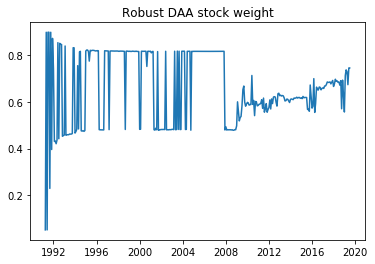

In [169]:
plt.plot('Dates','robust_w_stock',data=r_weights_df)
plt.title("Robust DAA stock weight")

Text(0.5, 1.0, 'Robust DAA bond weight')

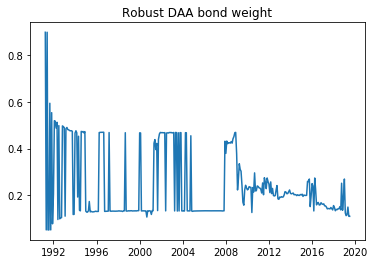

In [170]:
plt.plot('Dates','robust_w_bond',data=r_weights_df)
plt.title("Robust DAA bond weight")

Text(0.5, 1.0, 'Robust DAA bill weight')

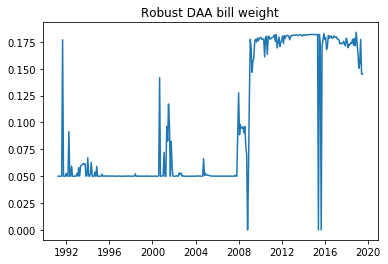

In [171]:
plt.plot('Dates','robust_w_bill',data=r_weights_df)
plt.title("Robust DAA bill weight")

### 6.2 Performance Evaluation

Below cell attempts to ensure that the proportion of investment in bill is reduced to 0 for outliers in the bill returns.

In [172]:
np.place(w_r[:,2], np.abs(r_actual[:,2])>5, 0)
w_r[np.abs(r_actual[:,2])>5]

array([[0.48066532, 0.46929671, 0.        ],
       [0.61937458, 0.19851546, 0.        ],
       [0.56025247, 0.26876236, 0.        ]])

### 6.2.1 Geometric Return

In [173]:
r_portfolio_robust = np.multiply(r_actual,w_r).sum(axis=1)
r_portfolio_bench = np.multiply(r_actual,w_bench).sum(axis=1)

In [174]:
robust_DAA_geo_return = ((((r_portfolio_robust[200:]+1)
                   .prod()**(1/r_portfolio_robust[200:].shape[0]))
                  -1) * 12)
robust_DAA_geo_return

0.16784655039664553

### 6.2.1 Standard Deviation of Return

In [175]:
robust_DAA_std = r_portfolio_robust[200:].std(ddof=1)
robust_DAA_std

0.09299296754868039

### 6.2.2 Maximum Drawdown

In [176]:
robust_DAA_mdd = 1-(r_portfolio_robust[200:] + 1).cumprod().min()
robust_DAA_mdd

0.47304784802558286

### 6.2.3 Calmar Ratio

In [177]:
robust_DAA_Calmar = robust_DAA_geo_return/robust_DAA_mdd
robust_DAA_Calmar 

0.3548193932119278

### 6.2.4 Average Excess Return

In [178]:
robust_Avg_Excess_Return = (
                  robust_DAA_geo_return - Bench_geo_return)
robust_Avg_Excess_Return

0.08535159808448434

In [179]:
robust_Avg_Excess_Return_wrt_original = (
                    robust_DAA_geo_return - DAA_geo_return)
robust_Avg_Excess_Return_wrt_original

0.03924805018899136

### 6.2.5 Tracking Error

In [180]:
robust_Tracking_Error = ((r_portfolio_robust[200:] 
                  - r_portfolio_bench[200:])
                 .std(ddof=1) *np.sqrt(12))
robust_Tracking_Error

0.3107965421699985

In [181]:
robust_Tracking_Error_wrt_original = ((
                    r_portfolio_robust[200:] 
                  - r_portfolio_actual[200:])
                 .std(ddof=1) *np.sqrt(12))
robust_Tracking_Error_wrt_original

0.06326300690528569

### 6.2.6 Information Ratio

In [182]:
robust_IR = robust_Avg_Excess_Return/robust_Tracking_Error
robust_IR

0.2746220967857454

In [183]:
robust_IR_wrt_original = (
    robust_Avg_Excess_Return_wrt_original/
    robust_Tracking_Error_wrt_original)
robust_IR_wrt_original

0.6203949528948511

### 6.2.7 CER Gain

In [184]:
robust_U_bar_actual = (-(1+r_portfolio_robust)**(-1)).mean()
robust_U_bar_bench = (-(1+r_portfolio_bench)**(-1)).mean()

In [185]:
robust_CER_actual = ((-robust_U_bar_actual)**(-1) -1)*12
CER_bench = ((-U_bar_bench)**(-1) -1)*12

In [186]:
CER_gain = robust_CER_actual - CER_bench
CER_gain

0.04340854156391405

In [187]:
CER_gain_wrt_original = robust_CER_actual - CER_actual
CER_gain_wrt_original

0.027058412431287593

### 6.3 Perturbations

The purpose of this section is to observe how sensitive the performance of the portfolio would be for different realization of $\Sigma_{BL}$ by adding randomly generated matrices to $\Sigma_{BL}$ .

In [188]:
N=100
w_collect = np.zeros((N,w.shape[0],w.shape[1]))
return_collect = []
std_collect = []
mdd_collect = []
calmar_collect = []
avg_excess_return_collect = []
tracking_error_collect = []
IR_collect = []
CER_gain_collect = []

perturb = np.random.random((N,340,3,3))*1e-4
for r in range(N):
    cone1 = '+'.join([f'((w{i}-w_bench[{i}])*(Sigma_BL[i]+perturb[r,i])[{i},{j}]*(w{j}-w_bench[{j}]))'\
                     for i in range(3) for j in range(3)])
    w_LB = 0.05*np.ones(3)
    w_bench = np.array([0.65,0.3,0.05])
    TE=0.02
    w_r_perturb = np.array([np.nan,np.nan,np.nan]).reshape(-1,3)
    for i in range(20,len(r_actual)):
        # Create a new model
            model = Model("qcp")
            model.setParam('OutputFlag', 0)

            # Create variables
            w0 = model.addVar(name="w0")
            w1 = model.addVar(name="w1")
            w2 = model.addVar(name="w2")
            z  = model.addVar(name="z")
            # Set objective: x
            obj = m[i][0][0]*w0 + m[i][1][0]*w1 + m[i][2][0]*w2 - z
            model.setObjective(obj, GRB.MAXIMIZE)

            model.addConstr(w0 + w1 + w2 == 1, "c0")
            model.addConstr(w0  >= w_LB[0], "c1")
            model.addConstr(w1  >= w_LB[1], "c2")
            model.addConstr(w2  >= w_LB[2], "c3")

            # Add second-order cone: 
            eval('model.addConstr(' + cone + '<= (TE**2 *(1/12)), "qc0")')
            eval('model.addConstr(' + cone1 + '<= z/q**2, "qc1")')
            model.optimize()

            w_r_perturb = np.concatenate(
                (w,np.array([model.getVars()[i].x 
                for i in range(3)]).reshape(-1,3)))

    w_collect[r] = w_r_perturb[1:,:]
    r_portfolio_perturb = np.multiply(
        r_actual,w_r_perturb[1:,:]).sum(axis=1)
    cum_return = np.array(
        [x if x>0 else 1 for x in (r_portfolio_perturb[200:]+1)])
    return_collect += [
        (((cum_return.prod()**(
            1/r_portfolio_perturb[200:].shape[0])) -1) * 12)]
    std_collect += [r_portfolio_perturb[200:].std(ddof=1)]
    mdd_collect += [1-cum_return.cumprod().min()]
    calmar_collect += [return_collect[-1]/mdd_collect[-1]]
    avg_excess_return_collect += [
        return_collect[-1] - Bench_geo_return]
    tracking_error_collect += [
        ((r_portfolio_perturb[200:] 
            - r_portfolio_bench[200:])
            .std(ddof=1) *np.sqrt(12))]
    IR_collect += [
        avg_excess_return_collect[-1]/
        tracking_error_collect[-1]]
    perturb_U_bar_actual = (
        -(1+r_portfolio_perturb)**(-1)).mean()
    perturb_CER_actual = (
        (-perturb_U_bar_actual)**(-1) -1)*12
    CER_gain_collect += [perturb_CER_actual - CER_bench]

In [189]:
perturb_df = pd.DataFrame(std_collect)
i=1
for item in [mdd_collect,calmar_collect,
             avg_excess_return_collect,
             tracking_error_collect,
             IR_collect,CER_gain_collect]:
    exec(f"perturb_df['{i}'] = item")
    i+=1
columns = ['std','mdd','calmar',
           'avg_excess_return',
           'tracking_error','IR','CER_gain']
perturb_df.columns = columns

In [190]:
perturb_df.head()

,std,mdd,calmar,avg_excess_return,tracking_error,IR,CER_gain
0,0.191727,0.390951,0.701956,0.191935,0.471457,0.407111,0.188997
1,0.191727,0.390951,0.701959,0.191936,0.471457,0.407114,0.188997
2,0.191727,0.390951,0.701953,0.191934,0.471457,0.407109,0.188996
3,0.191727,0.390951,0.701948,0.191932,0.471457,0.407105,0.188995
4,0.191727,0.390951,0.701951,0.191933,0.471457,0.407107,0.188996


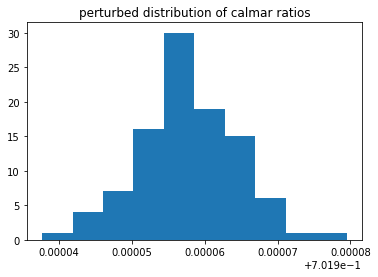

In [191]:
n_bins=10

plt.hist(perturb_df['calmar'])
plt.title('perturbed distribution of calmar ratios')
plt.show()

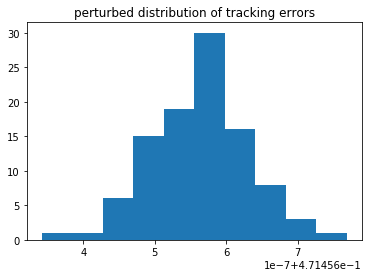

In [192]:
n_bins=10

plt.hist(perturb_df['tracking_error'])
plt.title('perturbed distribution of tracking errors')
plt.show()

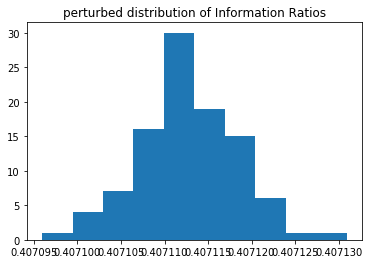

In [193]:
n_bins=10

plt.hist(perturb_df['IR'])
plt.title('perturbed distribution of Information Ratios')
plt.show()

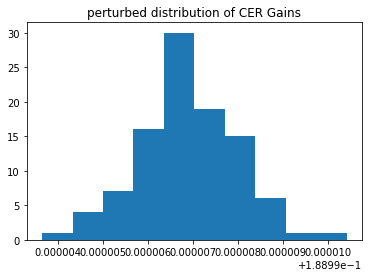

In [194]:
n_bins=10

plt.hist(perturb_df['CER_gain'])
plt.title('perturbed distribution of CER Gains')
plt.show()